This code provide the estmation results (calibration) between the change of estimated loss without train data z and acutal loss without loss 

In [2]:
import numpy as np
import tensorflow as tf
from sklearn import linear_model

from in

tf version: 2.3.0


In [2]:
def get_2class_mnist(num_a, num_b):
    from tensorflow.keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data(path='mnist.npz')
    x_train, x_test = x_train.reshape([-1, 784]) / 255.0, x_test.reshape([-1, 784]) / 255.0
    x_train_2class, y_train_2class = from10to2classes(x_train, y_train, num_a, num_b)
    x_test_2class, y_test_2class = from10to2classes(x_test, y_test, num_a, num_b)

    return (x_train_2class, y_train_2class), (x_test_2class, y_test_2class)

def from10to2classes(x, y, num_a, num_b):
    is_num_a, is_num_b = y == num_a, y == num_b
    x_2class = np.concatenate([x[is_num_a], x[is_num_b]])
    y_2class = np.concatenate([np.ones(is_num_a.sum()), np.zeros(is_num_b.sum())]).reshape([-1, 1])

    return x_2class, y_2class

In [3]:
NUM_A, NUM_B = 1, 7
WEIGHT_DECAY = 0.01

(x_train, y_train), (x_test, y_test) = get_2class_mnist(NUM_A, NUM_B)
train_sample_num = len(x_train)

# prepare sklearn model to train w
C = 1.0 / (train_sample_num * WEIGHT_DECAY)
sklearn_model = linear_model.LogisticRegression(C=C, solver='lbfgs', tol=1e-8, fit_intercept=True)
sklearn_model.fit(x_train, y_train.ravel())

LogisticRegression(C=0.007688167909587146, tol=1e-08)

In [4]:
w_opt = sklearn_model.coef_.ravel()
b_opt = sklearn_model.intercept_.ravel()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(784,)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', use_bias=True))
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

w_ref = np.load('../cache/compare/w.npy')
model.set_weights([w_ref.reshape(784, 1), b_opt])

#### grad_z test

In [5]:
TEST_INDEX = 5

x_test_tf = tf.convert_to_tensor(x_test[TEST_INDEX: TEST_INDEX+1])
y_test_tf = tf.convert_to_tensor(y_test[TEST_INDEX: TEST_INDEX+1])

test_grad_my = grad_z(x_test_tf, y_test_tf, f=model)

# as vector
test_grad_my_coef = test_grad_my[0].numpy().ravel() 
test_grad_my_bias = test_grad_my[1].numpy().ravel() 
test_grad_my_coef.shape, test_grad_my_bias.shape

((784,), (1,))

###### grad_z_train

In [6]:
WEIGHT_DECAY = 0.01

x_train_tf = tf.convert_to_tensor(x_train[0:2])
y_train_tf = tf.convert_to_tensor(y_train[0:2])

train_grad_my = grad_z(x_train_tf, y_train_tf, model, for_train=True)

# as vector
train_grad_my_coef = train_grad_my[0].numpy().ravel() 
train_grad_my_bias = train_grad_my[1].numpy().ravel() 

train_grad_my_coef.shape, train_grad_my_bias.shape

((784,), (1,))

###### hvp

In [7]:
x_train_tf = tf.convert_to_tensor(x_train)
y_train_tf = tf.convert_to_tensor(y_train)
x_test_tf = tf.convert_to_tensor(x_test[TEST_INDEX: TEST_INDEX+1])
y_test_tf = tf.convert_to_tensor(y_test[TEST_INDEX: TEST_INDEX+1])

test_grad_my = grad_z(x_test_tf, y_test_tf, f=model)

    
hvp_my = get_hessian_vector_product(x_train_tf, y_train_tf, model, test_grad_my)

In [8]:
x_train_tf = tf.convert_to_tensor(x_train)
y_train_tf = tf.convert_to_tensor(y_train)

print("X train, Y train shape:", x_train_tf.shape, y_train_tf.shape)


s_test_my = get_inv_hessian_vector_product(x_train_tf, y_train_tf, test_grad_my, model,
                                            scale=10,
                                            n_recursion=1000,
                                            verbose=False)

s_test_ref = np.load('../cache/compare/hvp.npy')  # List

X train, Y train shape: (13007, 784) (13007, 1)


In [10]:
from influence_utils import multiply_for_influe

train_sample_num = len(x_train_tf)
loss_diff_approx = np.zeros(train_sample_num)

for i in range(train_sample_num):
    
    # Get train grad
    train_grad = grad_z(x_train_tf[i: i+1], y_train[i: i+1], model, for_train=True)
    loss_diff_approx[i] = multiply_for_influe(train_grad, s_test_my) / train_sample_num

    
    if i % 1000 == 0:
        print('[{}/{}] Estimated loss diff: {}'.format(i+1, train_sample_num, loss_diff_approx[i]))

[1/13007] Estimated loss diff: -8.192967044073954e-07
[1001/13007] Estimated loss diff: -8.23931773716499e-07
[2001/13007] Estimated loss diff: -1.5307424263917686e-06
[3001/13007] Estimated loss diff: -6.768512706844903e-07
[4001/13007] Estimated loss diff: 1.3205292248017093e-06
[5001/13007] Estimated loss diff: -7.239504803624082e-07
[6001/13007] Estimated loss diff: -8.207535633255314e-07
[7001/13007] Estimated loss diff: -4.886687748484125e-07
[8001/13007] Estimated loss diff: -6.688261282946529e-07
[9001/13007] Estimated loss diff: -7.721387722919056e-07
[10001/13007] Estimated loss diff: -7.959436515333711e-07
[11001/13007] Estimated loss diff: -8.061566682804659e-07
[12001/13007] Estimated loss diff: -4.749312495509612e-06
[13001/13007] Estimated loss diff: -6.207566671236688e-07


##### influence function calibration

In [11]:
# Test original loss

TEST_INDEX = 5

x_test_tf = tf.convert_to_tensor(x_test[TEST_INDEX: TEST_INDEX+1])
y_test_tf = tf.convert_to_tensor(y_test[TEST_INDEX: TEST_INDEX+1])

w_ref = sklearn_model.coef_.T.ravel()
b_ref = sklearn_model.intercept_.ravel()
model.set_weights([w_ref.reshape(784, 1), b_ref])


y_hat = model.predict(x_test_tf)
test_loss_ori = tf.keras.losses.binary_crossentropy(y_test_tf, y_hat)

In [12]:
SAMPLE_NUM = 50 

# get high and low loss diff indice
sorted_indice = np.argsort(loss_diff_approx)
sample_indice = np.concatenate([sorted_indice[-int(SAMPLE_NUM/2):], sorted_indice[:int(SAMPLE_NUM/2)]])


# calculate true loss diff
loss_diff_true = np.zeros(SAMPLE_NUM)
for i, index in zip(range(SAMPLE_NUM), sample_indice):
    print('[{}/{}]'.format(i+1, SAMPLE_NUM))

    # get minus one dataset
    x_train_minus_one = np.delete(x_train, index, axis=0)
    y_train_minus_one = np.delete(y_train, index, axis=0)

    # retrain
    C = 1.0 / ((train_sample_num - 1) * WEIGHT_DECAY)
    sklearn_model_minus_one = linear_model.LogisticRegression(C=C, fit_intercept=False, tol=1e-8, solver='lbfgs')
    sklearn_model_minus_one.fit(x_train_minus_one, y_train_minus_one.ravel())
    print('LBFGS training took {} iter.'.format(sklearn_model_minus_one.n_iter_))

    # Reference model (deep learning)
    w_ref = sklearn_model_minus_one.coef_.T.ravel()
    b_ref = sklearn_model_minus_one.intercept_.ravel()
    model.set_weights([w_ref.reshape(784, 1), b_ref])
    

    # get retrain loss
    x_test_tf = tf.convert_to_tensor(x_test[TEST_INDEX: TEST_INDEX+1])
    y_test_tf = tf.convert_to_tensor(y_test[TEST_INDEX: TEST_INDEX+1])
    y_hat = model(x_test_tf)
    test_loss_retrain = tf.keras.losses.binary_crossentropy(y_test_tf, y_hat)

    # get true loss diff
    loss_diff_true[i] = test_loss_retrain.numpy() - test_loss_ori.numpy()

    print('Original loss       :{}'.format(test_loss_ori))
    print('Retrain loss        :{}'.format(test_loss_retrain))
    print('True loss diff      :{}'.format(loss_diff_true[i]))
    print('Estimated loss diff :{}'.format(loss_diff_approx[index]))

[1/50]
LBFGS training took [23] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.01705281]
True loss diff      :0.00012713298201560974
Estimated loss diff :2.4732500225926487e-05
[2/50]
LBFGS training took [21] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.01700836]
True loss diff      :8.269213140010834e-05
Estimated loss diff :2.502097544226885e-05
[3/50]
LBFGS training took [22] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.01706263]
True loss diff      :0.00013695470988750458
Estimated loss diff :2.511500672996388e-05
[4/50]
LBFGS training took [22] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.01701976]
True loss diff      :9.408965706825256e-05
Estimated loss diff :2.534409489892489e-05
[5/50]
LBFGS training took [23] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.0170214]
True loss diff      :9.572692215442657e-05
Estimated loss diff :2.7381279650782607e-05
[6/50]
LBFGS training took [23] iter.

LBFGS training took [23] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.01687524]
True loss diff      :-5.0436705350875854e-05
Estimated loss diff :-8.627587369872778e-05
[45/50]
LBFGS training took [21] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.01689106]
True loss diff      :-3.4615397453308105e-05
Estimated loss diff :-8.438059337969296e-05
[46/50]
LBFGS training took [22] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.01686681]
True loss diff      :-5.8863312005996704e-05
Estimated loss diff :-8.206564408651165e-05
[47/50]
LBFGS training took [21] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.0169227]
True loss diff      :-2.9709190130233765e-06
Estimated loss diff :-7.817268694075833e-05
[48/50]
LBFGS training took [23] iter.
Original loss       :[0.01692567]
Retrain loss        :[0.01692634]
True loss diff      :6.668269634246826e-07
Estimated loss diff :-7.80373777353013e-05
[49/50]
LBFGS training took [21]

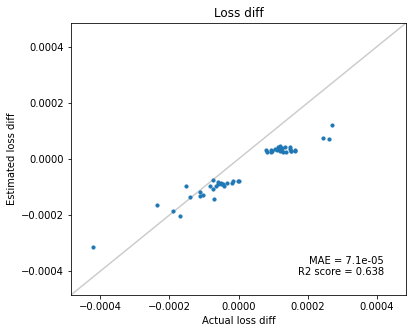

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

def visualize_result(actual_loss_diff, estimated_loss_diff):
    max_abs = np.max([np.abs(actual_loss_diff), np.abs(estimated_loss_diff)])
    min_, max_ = -max_abs * 1.15, max_abs * 1.15
    
    plt.rcParams['figure.figsize'] = 6, 5
    plt.scatter(actual_loss_diff, estimated_loss_diff, zorder=2, s=10)
    plt.title('Loss diff')
    plt.xlabel('Actual loss diff')
    plt.ylabel('Estimated loss diff')
    
    range_ = [min_, max_]
    plt.plot(range_, range_, 'k-', alpha=0.2, zorder=1)
    text = 'MAE = {:.03}\nR2 score = {:.03}'.format(mean_absolute_error(actual_loss_diff, estimated_loss_diff),
                                                    r2_score(actual_loss_diff, estimated_loss_diff))
    plt.text(max_abs, -max_abs, text, verticalalignment='bottom', horizontalalignment='right')
    plt.xlim(min_, max_)
    plt.ylim(min_, max_)
    plt.show()
    
visualize_result(loss_diff_true, loss_diff_approx[sample_indice])